# Preprocessing Keyboard Data

Three types of data are recorded.

1. Old data: Data for Basem and Brian. Using first iteration of keyboard_recorder.
2. research: Originally from the KeyStroke dataset used in the paper. Only the non-Zoom audio
3. New Data: New data recorded after the new keyboard_recorder was made.

Steps for pulling together data

1. Load the data folders
2. Preprocess the files by extracting keystrokes (personal method vs Keystroke method)
3. Encode and format data together across all folders.


End result:
* One pickle file of tabular data
* One folder of data preprocessed for multi-modal modal



In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yaml
import librosa
import librosa.display
import soundfile as sf
import shutil
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Old Data before rework (Basem, Brian)

In [32]:
# Define the path to the data folder
data_folder = '../data/old_data/'
output_dir='../preprocessed_data/'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Delete the folder and its contents
os.makedirs(output_dir)

# Initialize an empty list to store the data
key_data_list = []
sentence_data_list = []

# Loop through all user folders in the data folder
for user_folder in os.listdir(data_folder):
    if 'Keystroke' in user_folder:
        continue
    user_folder_path = os.path.join(data_folder, user_folder)
    if os.path.isdir(user_folder_path):  # Check if it's a directory
        key_folder_path = os.path.join(user_folder_path, 'data', 'key_data')
        sentence_folder_path = os.path.join(user_folder_path, 'data', 'sentence_data')

        # Key data, then sentence data
        # for internal_folder in [key_folder_path, sentence_folder_path]:
        for file_name in os.listdir(key_folder_path):
            # key_folder_path = os.path.join(data_folder, user_folder)
            # Check if the file is a YAML file
            if file_name.endswith('.yaml'):
                # Extract key_pressed value from the filename
                key_pressed = file_name.split('_')[2]
                
                # Construct the full path to the YAML file
                yaml_file_path = os.path.join(key_folder_path, file_name)
                
                # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
                with open(yaml_file_path, 'r') as file:
                    lines = file.readlines()
                
                filtered_lines = []
                skip = False
                for line in lines:
                    if line.strip().startswith('key_pressed:'):
                        skip = True
                    if skip and line.strip().startswith('keyboard_name:'):
                        skip = False
                    if not skip:
                        filtered_lines.append(line)
                
                # Load the filtered lines into a dictionary
                yaml_data = yaml.safe_load(''.join(filtered_lines))
                
                # Add the user, audio file name, and key_pressed information
                yaml_data['user'] = user_folder
                # yaml_data['audio_file'] = file_name.replace('.yaml', f'_{user_folder}.wav')
                # original_file = file_name.replace('.yaml', '.wav')
                yaml_data['audio_file'] = file_name.replace('.yaml', '.wav') # Assuming audio files are in .wav format
                yaml_data['key_pressed'] = key_pressed

                # Copy the audio file to the output directory
                original_audio_file = yaml_data['audio_file']
                new_audio_file_name = original_audio_file.replace('.wav', f'_{user_folder}.wav')
                source_audio_file_path = os.path.join(key_folder_path, original_audio_file)
                destination_audio_file_path = os.path.join(output_dir, new_audio_file_name)
                shutil.copy2(source_audio_file_path, destination_audio_file_path)
                yaml_data['audio_file'] = new_audio_file_name
                key_data_list.append(yaml_data)

# Convert the list of dictionaries to a DataFrame
key_df = pd.DataFrame(key_data_list)
sentence_df = pd.DataFrame(sentence_data_list)

# Display the DataFrame
key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720062427,Brian,key_press_6_1720062427_Brian.wav,6
1,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720064881,Brian,key_press_space_1720064881_Brian.wav,space
2,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720064791,Brian,key_press_._1720064791_Brian.wav,.
3,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720063824,Brian,key_press_s_1720063824_Brian.wav,s
4,0.18,0.18,0.09,0.09,44100.0,0,1,Keychron Q3,80%_Tenkeyless,mechanical,2,0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1720063368,Brian,key_press_y_1720063368_Brian.wav,y


### New Data

Find the peak for each audio file, then seperate them out.

In [33]:
def calculate_energy(y, sr):
    stft_result = np.abs(librosa.stft(y))
    energy = np.sum(stft_result**2, axis=0)
    energy = energy / np.max(energy)
    return energy

def sliding_window_average(energy, window_size):
    averaged_energy = np.convolve(energy, np.ones(window_size)/window_size, mode='same')
    return averaged_energy

def get_yaml_file(folder_path):
    for file in os.listdir(folder_path):
        if (file.endswith(".yaml") or file.endswith(".yml")):
            yaml_file_path = os.path.join(folder_path, file)
            # Get all yaml data first
            # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
            with open(yaml_file_path, 'r') as file:
                lines = file.readlines()
            
            # Load the filtered lines into a dictionary
            yaml_data = yaml.safe_load(''.join(lines))
            
            # Add the user, audio file name, and key_pressed information
            user_keyboard_name = yaml_data['keyboard_name']
            user_keyboard_size = yaml_data['keyboard_size']
            keyboard_type = yaml_data['keyboard_type']
            switch_color = yaml_data['switch_color']
            return user_keyboard_name, user_keyboard_size, keyboard_type, switch_color
    return None

def extract_keystrokes(data_folder, low_threshold, high_threshold, output_dir,
                       window_size=50, target_duration=1.0, give_plot=False, debug=False):
    
    for user_folder in os.listdir(data_folder):
        if 'Keystroke' in user_folder:
            continue
        user_folder_path = os.path.join(data_folder, user_folder)
        audio_data = []
        if os.path.isdir(user_folder_path):  # Check if it's a directory
            key_folder_path = os.path.join(user_folder_path, 'key_data')
            user_keyboard_name, user_keyboard_size, keyboard_type, switch_color = get_yaml_file(key_folder_path)
            if not key_folder_path:
                raise('Yaml file for data not found')

            for file_name in os.listdir(key_folder_path):
                if file_name.endswith('.yaml'):
                    continue
                        
                elif file_name.endswith('.wav'):
                    # Wav file
                    key_pressed = file_name.split('_')[2].lower()

                    wav_file_path = os.path.join(key_folder_path, file_name)

                    y, sr = librosa.load(wav_file_path, sr=None)
                    energy = calculate_energy(y, sr)
                    averaged_energy = sliding_window_average(energy, window_size)
                    
                    keystroke_indices = np.where(averaged_energy > low_threshold)[0]
                    
                    keystroke_events = []
                    if len(keystroke_indices) > 0:
                        start_idx = keystroke_indices[0]
                        for i in range(1, len(keystroke_indices)):
                            if keystroke_indices[i] - keystroke_indices[i-1] > 1:
                                end_idx = keystroke_indices[i-1]
                                keystroke_events.append((start_idx, end_idx))
                                start_idx = keystroke_indices[i]
                        keystroke_events.append((start_idx, keystroke_indices[-1]))
                    
                    filtered_keystroke_events = []
                    for start_frame, end_frame in keystroke_events:
                        if np.max(averaged_energy[start_frame:end_frame]) > high_threshold:
                            length = end_frame - start_frame
                            extension = int(0.1 * length)
                            start_frame = max(0, start_frame - extension)
                            end_frame = min(len(averaged_energy), end_frame + extension)
                            filtered_keystroke_events.append((start_frame, end_frame))
                    
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    
                    for i, (start_frame, end_frame) in enumerate(filtered_keystroke_events[1:]):
                        start_sample = librosa.frames_to_samples(start_frame)
                        end_sample = librosa.frames_to_samples(end_frame + 1)
                        
                        keystroke_audio = y[start_sample:end_sample]
                        
                        # Calculate required padding
                        target_samples = int(target_duration * sr)
                        current_samples = len(keystroke_audio)
                        padding_needed = target_samples - current_samples
                        if padding_needed > 0:
                            pad_before = padding_needed // 2
                            pad_after = padding_needed - pad_before
                            keystroke_audio = np.pad(keystroke_audio, (pad_before, pad_after), 'constant')
                        
                        output_path = os.path.join(output_dir, f'key_press_{key_pressed}_{i}_{user_folder}.wav')
                        sf.write(output_path, keystroke_audio, sr)
                        if debug:
                            print(f'Saved keystroke {i} to {output_path}')
                        
                        # Write the filename and additional data to a dataframe.
                        audio_data.append([user_keyboard_name,
                                           user_keyboard_size, 
                                           keyboard_type,
                                           switch_color,
                                           f'key_press_{key_pressed}_{i}_{user_folder}.wav',
                                           key_pressed])

                    if give_plot:
                        # Plot for visualization
                        time = np.linspace(0, len(y) / sr, len(y))
                        frames_time = np.linspace(0, len(energy) * window_size / sr, len(energy))
                        
                        plt.figure(figsize=(15, 7))
                        # plt.plot(time, y, label='Audio Signal')
                        plt.plot(frames_time, averaged_energy, label='Averaged Energy', color='orange')
                        plt.axhline(y=low_threshold, color='black', linestyle=':', label='Low Threshold')
                        plt.axhline(y=high_threshold, color='green', linestyle=':', label='High Threshold')
                        for start_frame, end_frame in filtered_keystroke_events[1:]:
                            plt.axvline(x=start_frame * window_size / sr, color='red', linestyle='-', linewidth=0.2)
                            plt.axvline(x=end_frame * window_size / sr, color='magenta', linestyle='-', linewidth=0.2)
                        plt.xlabel('Time (s)')
                        plt.ylabel('Amplitude / Averaged Energy')
                        plt.legend()
                        plt.title('Keystroke Detection Visualization')
                        plt.show()
    key_df = pd.DataFrame(data=audio_data, columns=['keyboard_name', 'keyboard_size', 'keyboard_type',
                                                    'switch_color', 'audio_file', 'key_pressed'])
    return key_df

# Extract keystrokes with the chosen threshold
audio_path='../data/new_data/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
give_plot=False

new_key_df = extract_keystrokes(data_folder=audio_path,
                   low_threshold=low_threshold,
                   high_threshold=high_threshold,
                   output_dir=output_dir,
                   window_size=window_size,
                   give_plot=False)
new_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_0_Newman.wav,`
1,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_1_Newman.wav,`
2,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_2_Newman.wav,`
3,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_3_Newman.wav,`
4,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_4_Newman.wav,`


-------------

Continue here. Function above now works. 

1. Need to grab original audio data
2. Need a combination function for all dataframes

### Grab original audio research data. (not done)

In [34]:
# Extract keystrokes with the chosen threshold
audio_path='../data/research/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
give_plot=False

research_df = extract_keystrokes(data_folder=audio_path,
                   low_threshold=low_threshold,
                   high_threshold=high_threshold,
                   output_dir=output_dir,
                   window_size=window_size,
                   give_plot=give_plot)
research_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,MacbookProM1,65%_Compact,Scissor,None,key_press_b_0_MBPWavs.wav,b
1,MacbookProM1,65%_Compact,Scissor,None,key_press_b_1_MBPWavs.wav,b
2,MacbookProM1,65%_Compact,Scissor,None,key_press_b_2_MBPWavs.wav,b
3,MacbookProM1,65%_Compact,Scissor,None,key_press_b_3_MBPWavs.wav,b
4,MacbookProM1,65%_Compact,Scissor,None,key_press_b_4_MBPWavs.wav,b


### Combine all three dataframes

In [35]:
combined_key_df = pd.concat([key_df, new_key_df, research_df], ignore_index=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,Keychron Q3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720062e+09,Brian,key_press_6_1720062427_Brian.wav,6
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,Keychron Q3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720065e+09,Brian,key_press_space_1720064881_Brian.wav,space
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,Keychron Q3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720065e+09,Brian,key_press_._1720064791_Brian.wav,.
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,Keychron Q3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720064e+09,Brian,key_press_s_1720063824_Brian.wav,s
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,Keychron Q3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720063e+09,Brian,key_press_y_1720063368_Brian.wav,y


---------
---------
---------
## Begin processing data

## Add Keyboard Material Column

In [36]:
print(np.unique([name.lower().replace(" ", "") for name in combined_key_df['keyboard_name'].values]))

['dropctrlv1' 'keychronq3' 'macbookprom1']


In [37]:
material_mapper = {'dropctrlv1': 'aluminum',
                   'keychronq3': 'aluminum',
                   'macbookprom1': 'aluminum'}
combined_key_df['keyboard_name'] = combined_key_df['keyboard_name'].apply(lambda x: x.lower().replace(" ", ""))
combined_key_df['keyboard_material'] = combined_key_df['keyboard_name'].map(material_mapper)
# combined_key_df.drop('keyboard_name', axis=1, inplace=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed,keyboard_material
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720062e+09,Brian,key_press_6_1720062427_Brian.wav,6,aluminum
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720065e+09,Brian,key_press_space_1720064881_Brian.wav,space,aluminum
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720065e+09,Brian,key_press_._1720064791_Brian.wav,.,aluminum
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720064e+09,Brian,key_press_s_1720063824_Brian.wav,s,aluminum
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Microphone (3- USB PnP Audio De,Cherry MX Speed Silver,1.720063e+09,Brian,key_press_y_1720063368_Brian.wav,y,aluminum


## Add Keyboard Microhone Column cleanup

In [38]:
combined_key_df['name'].unique()

microphone_mapper = {'Mic/Inst (Samson G-Track Pro)': 'Samson_GTrack_Pro',
                     'Microphone (3- USB PnP Audio De': 'GenericPnP'}

combined_key_df['microphone'] = combined_key_df['name'].map(microphone_mapper)
combined_key_df.drop('name', axis=1, inplace=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,switch_color,timestamp,user,audio_file,key_pressed,keyboard_material,microphone
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Cherry MX Speed Silver,1.720062e+09,Brian,key_press_6_1720062427_Brian.wav,6,aluminum,GenericPnP
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Cherry MX Speed Silver,1.720065e+09,Brian,key_press_space_1720064881_Brian.wav,space,aluminum,GenericPnP
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Cherry MX Speed Silver,1.720065e+09,Brian,key_press_._1720064791_Brian.wav,.,aluminum,GenericPnP
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Cherry MX Speed Silver,1.720064e+09,Brian,key_press_s_1720063824_Brian.wav,s,aluminum,GenericPnP
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,keychronq3,80%_Tenkeyless,mechanical,2.0,0.0,Cherry MX Speed Silver,1.720063e+09,Brian,key_press_y_1720063368_Brian.wav,y,aluminum,GenericPnP


## Drop unneeded columns

In [39]:
unnecessary_cols = ['default_high_input_latency',
                    'default_high_output_latency',
                    'default_low_input_latency',
                    'default_low_output_latency',
                    'default_samplerate',
                    'hostapi',
                    'index',
                    'max_input_channels',
                    'max_output_channels',
                    'timestamp',]
combined_key_df.drop(unnecessary_cols, axis=1, inplace=True)

In [40]:
combined_key_df[combined_key_df['key_pressed'] == 'p']

,keyboard_name,keyboard_size,keyboard_type,switch_color,user,audio_file,key_pressed,keyboard_material,microphone
25,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063525_Brian.wav,p,aluminum,GenericPnP
37,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063544_Brian.wav,p,aluminum,GenericPnP
71,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063528_Brian.wav,p,aluminum,GenericPnP
182,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063534_Brian.wav,p,aluminum,GenericPnP
186,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063518_Brian.wav,p,aluminum,GenericPnP
208,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063538_Brian.wav,p,aluminum,GenericPnP
214,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063514_Brian.wav,p,aluminum,GenericPnP
263,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063521_Brian.wav,p,aluminum,GenericPnP
338,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063541_Brian.wav,p,aluminum,GenericPnP
368,keychronq3,80%_Tenkeyless,mechanical,Cherry MX Speed Silver,Brian,key_press_p_1720063531_Brian.wav,p,aluminum,GenericPnP


## One-hot encoding

keyboard sizes to ordinal encodings

In [41]:
# # Let's do the keyboard
# keyboard_sizes = {
#     '100%_FullSize': 5,
#     '96%_Compact': 4,
#     '80%_Tenkeyless': 3,
#     '75%_Compact_Tenkeyless': 2,
#     '65%_Compact(Default for Macbooks)': 1,
#     '60%_Mini': 0,
# }

# # Ordinally encode the 'keyboard_size' column
# combined_key_df['keyboard_size'] = combined_key_df['keyboard_size'].map(keyboard_sizes)
# # key_df.drop(['keyboard_size'], axis=1, inplace=True)
# combined_key_df.head()

Switch_colors to switch_type
switch_type(clicky, tactile, linear, NA(membrane))


In [42]:
switches_dict = {
    'Clicky': [
        'Cherry MX Blue', 'Cherry MX Green', 'Cherry MX White',
        'Gateron Blue', 'Gateron Green',
    ],
    'Tactile': [
        'Cherry MX Brown', 'Cherry MX Clear',
        'Gateron Brown', 'Halo True', 'Halo Clear',
    ],
    'Linear': [
        'Cherry MX Red', 'Cherry MX Black', 'Cherry MX Silent Red', 'Cherry MX Speed Silver',
        'Gateron Red', 'Gateron Black', 'Gateron Silent Red', 'Gateron Yellow',
        'Cherry MX Grey', 'Gateron Clear', 'Gateron White',
    ],
    'None': ['None']
}

def map_switch_type(switch):
    for key, values in switches_dict.items():
        if switch in values:
            return key
    print(f"{switch} was not in any category. setting to NA")
    return 'NA'  # If switch doesn't match any category

# Apply the mapping function to the 'switch_type' column
combined_key_df['switch_type'] = combined_key_df['switch_color'].map(lambda x: map_switch_type(x))
combined_key_df.drop(['switch_color'], axis=1, inplace=True)

combined_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,microphone,switch_type
0,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_6_1720062427_Brian.wav,6,aluminum,GenericPnP,Linear
1,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_space_1720064881_Brian.wav,space,aluminum,GenericPnP,Linear
2,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_._1720064791_Brian.wav,.,aluminum,GenericPnP,Linear
3,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_s_1720063824_Brian.wav,s,aluminum,GenericPnP,Linear
4,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_y_1720063368_Brian.wav,y,aluminum,GenericPnP,Linear


Todo:
- Onehot encode switch_colors now that youve sorted them
- ordinally encode the keyboard sizes
- onehot encode the keyboard material(aluminum, plastic, wood)

Fix names

## Final droppings

In [43]:
combined_key_df.drop(['microphone'], axis=1, inplace=True)
combined_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,switch_type
0,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_6_1720062427_Brian.wav,6,aluminum,Linear
1,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_space_1720064881_Brian.wav,space,aluminum,Linear
2,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_._1720064791_Brian.wav,.,aluminum,Linear
3,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_s_1720063824_Brian.wav,s,aluminum,Linear
4,keychronq3,80%_Tenkeyless,mechanical,Brian,key_press_y_1720063368_Brian.wav,y,aluminum,Linear


# Exploring Keyboard Data

1. Cluster data and visualize clusters
  - Use audio data features of some kind
  - Visualize those clusters

2. Show distribution of the key counts using a bar plot
3. Show pie chart distribution of Linear/Tactile/Clicky/(Scissor/None(Membrane)) keys.
3. Show what the average waveform for one key looks like using filters
  - Filter for switch type
  - Filter for material
  - Filter for shape
  - Filter for 



Keyboard map needs coordinates and shapes to match the actual piece
3. Show distribution of different keys for visualization.
4. Make Keyboard map

* **mel-spectrograms** as a method of feature extraction for a DL mode

* Augmentation:
    * Signals were time-shifted randomly by up to 40% in either direction.
        - Helps increase amount of data
    * Mel-spectrograms generated using:
        * 64 mel brands
        * Window length of 1024 samples
        * hop length of 500 (255 for macbook keystrokes, given their shorter length)
        - results in 64x64 images
    * After Mel-spectrograms, complete masking:
        * take random 10% of both time and frequency axis and setting all values within those ranges to the mean of the spectrogram.
            - 'blocking out' a portion of the image.
            - Called SpecAugment and was foudn to encourage the model to generalise and avoid overfitting.
    

**1. Clustering Audio Data**

Step 1: Feature Extraction from Audio

You’ll need to extract features from the audio files to use for clustering. Mel-frequency cepstral coefficients (MFCCs) are commonly used for this purpose.

In [44]:
# Function to extract MFCC features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

# Extract features and add them to the dataframe
dataviz_df = combined_key_df.copy(deep=True)
dataviz_df['features'] = dataviz_df['audio_file'].apply(lambda x: extract_features(f'../preprocessed_data/{x}'))

# Convert features to a numpy array
features = np.vstack(dataviz_df['features'].to_numpy())

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

**Step 2: Clustering**

Use K-Means or another clustering algorithm to cluster the audio data.

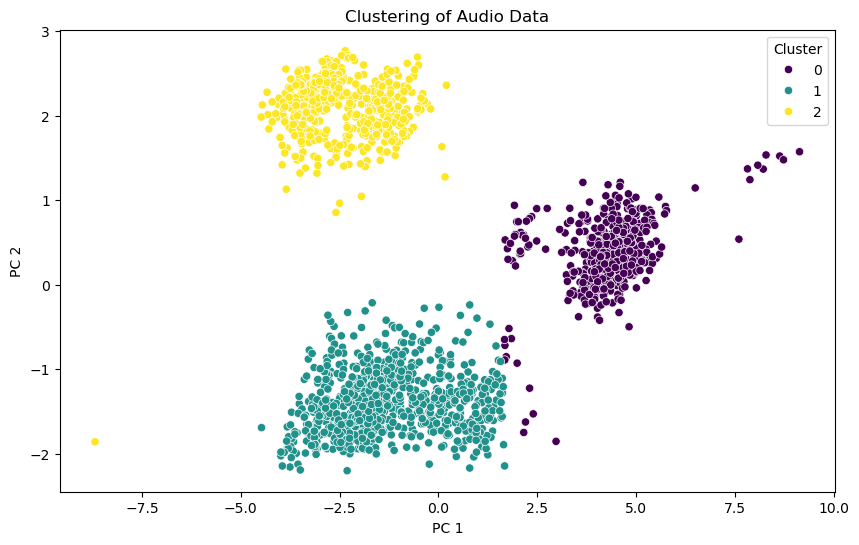

In [45]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(features_pca)

# Add clusters to the dataframe
dataviz_df['cluster'] = clusters

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['cluster'], palette='viridis')
plt.title('Clustering of Audio Data')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.show()

In [46]:
dataviz_df[dataviz_df['cluster'] == 2].head()

,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,switch_type,features,cluster
480,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_;_1720383500_Basem.wav,;,aluminum,Tactile,"[-713.5271, 107.55308, 24.349129, 22.53693, 9....",2
481,dropctrlv1,80%_Tenkeyless,mechanical,Basem,"key_press_,_1720383996_Basem.wav",",",aluminum,Tactile,"[-716.34033, 111.45904, 33.599037, 25.620358, ...",2
482,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_j_1720383315_Basem.wav,j,aluminum,Tactile,"[-721.3349, 112.90172, 34.508213, 26.43372, 15...",2
483,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Tactile,"[-706.98346, 111.735954, 27.941551, 29.110788,...",2
484,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_i_1720382741_Basem.wav,i,aluminum,Tactile,"[-700.2765, 117.15041, 19.398603, 17.565754, 1...",2


**Step 3: Filter by Additional Features**

You can add filters for keyboard_material, switch_type, and keyboard_size using seaborn or matplotlib to visualize their relation.

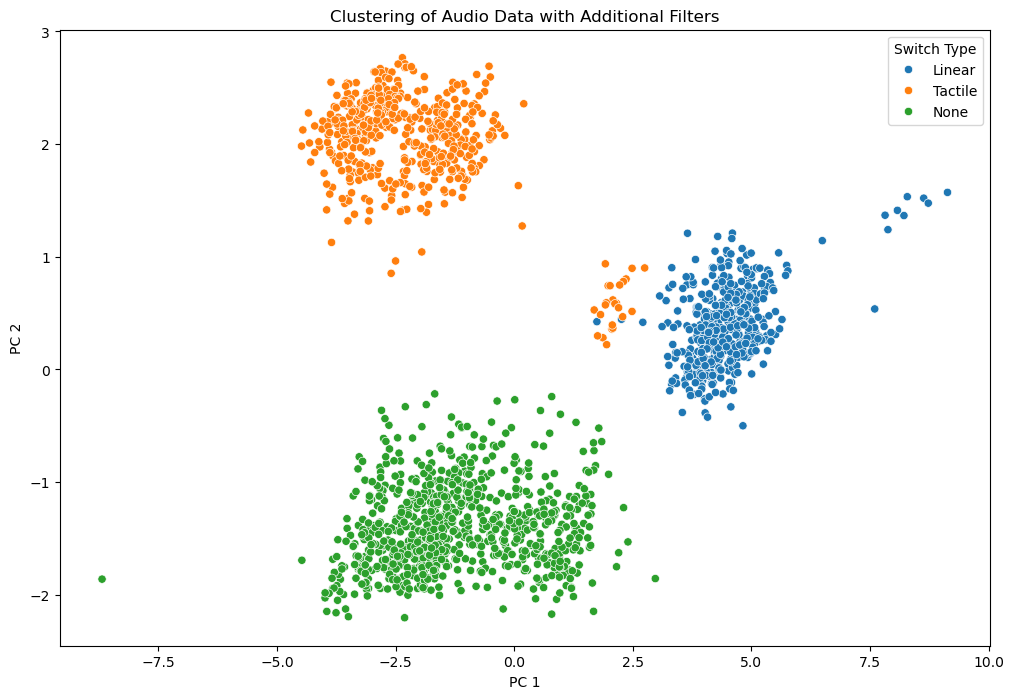

In [47]:
# Filtered Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['switch_type']) #, style=dataviz_df['keyboard_material'])
plt.title('Clustering of Audio Data with Additional Filters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Switch Type')
plt.show()

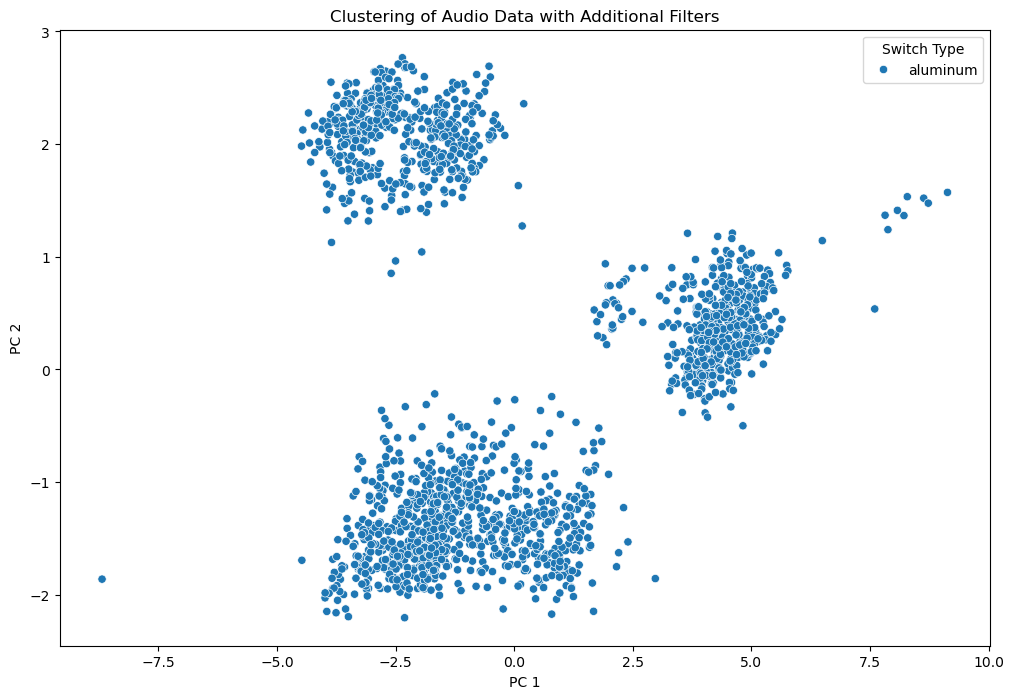

In [48]:
# Filtered Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['keyboard_material']) #, style=dataviz_df['keyboard_material'])
plt.title('Clustering of Audio Data with Additional Filters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Switch Type')
plt.show()

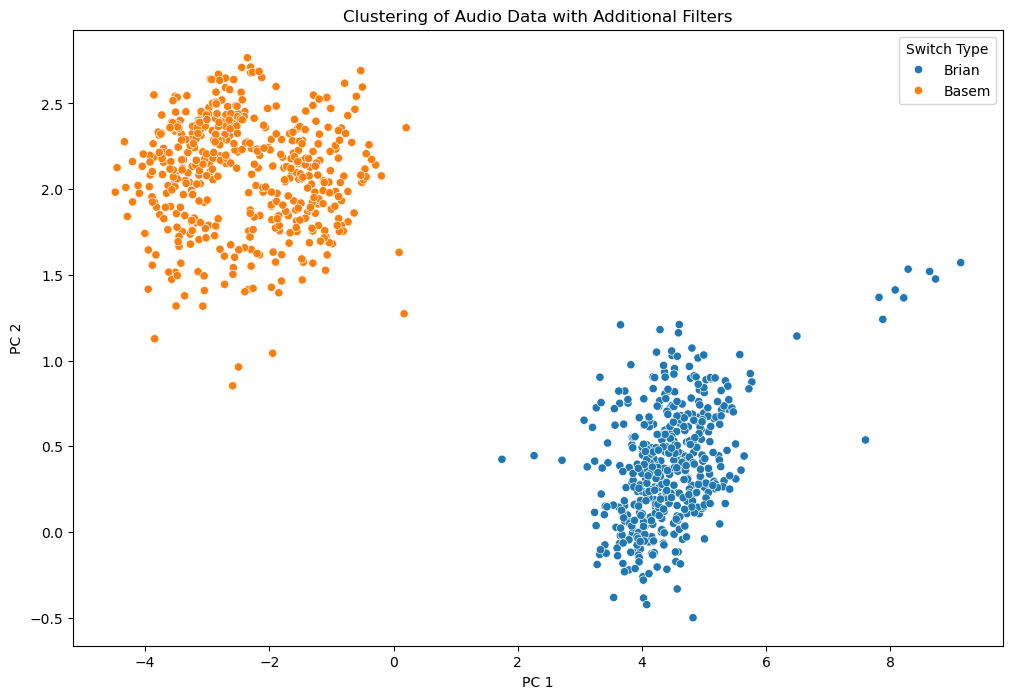

In [49]:
# Filtered Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['user']) #, style=dataviz_df['keyboard_material'])
plt.title('Clustering of Audio Data with Additional Filters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Switch Type')
plt.show()

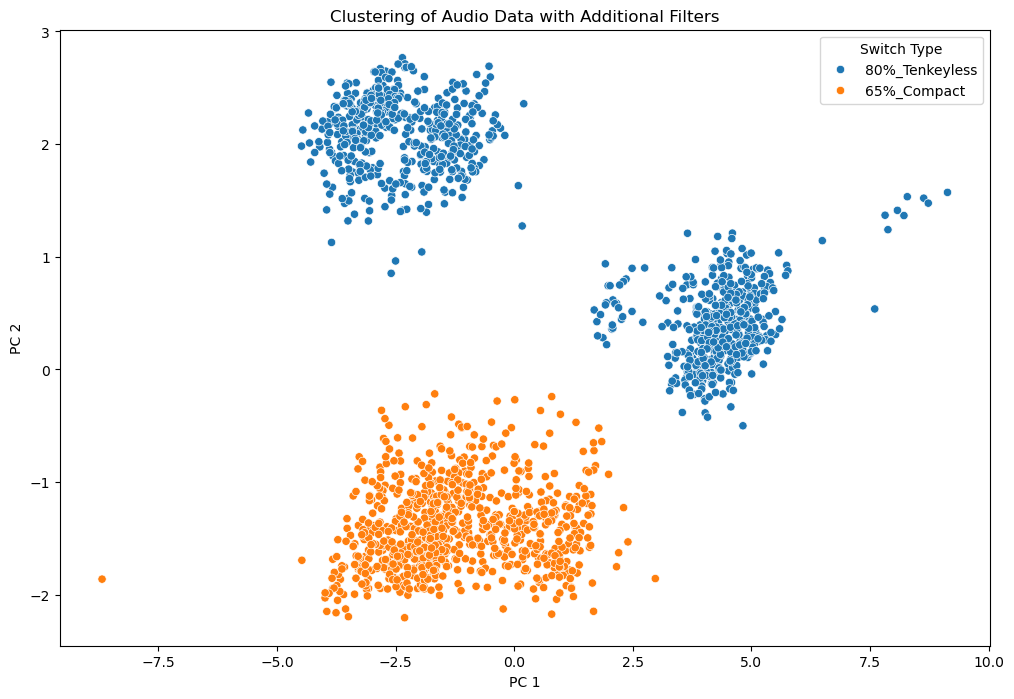

In [50]:
# Filtered Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['keyboard_size']) #, style=dataviz_df['keyboard_material'])
plt.title('Clustering of Audio Data with Additional Filters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Switch Type')
plt.show()

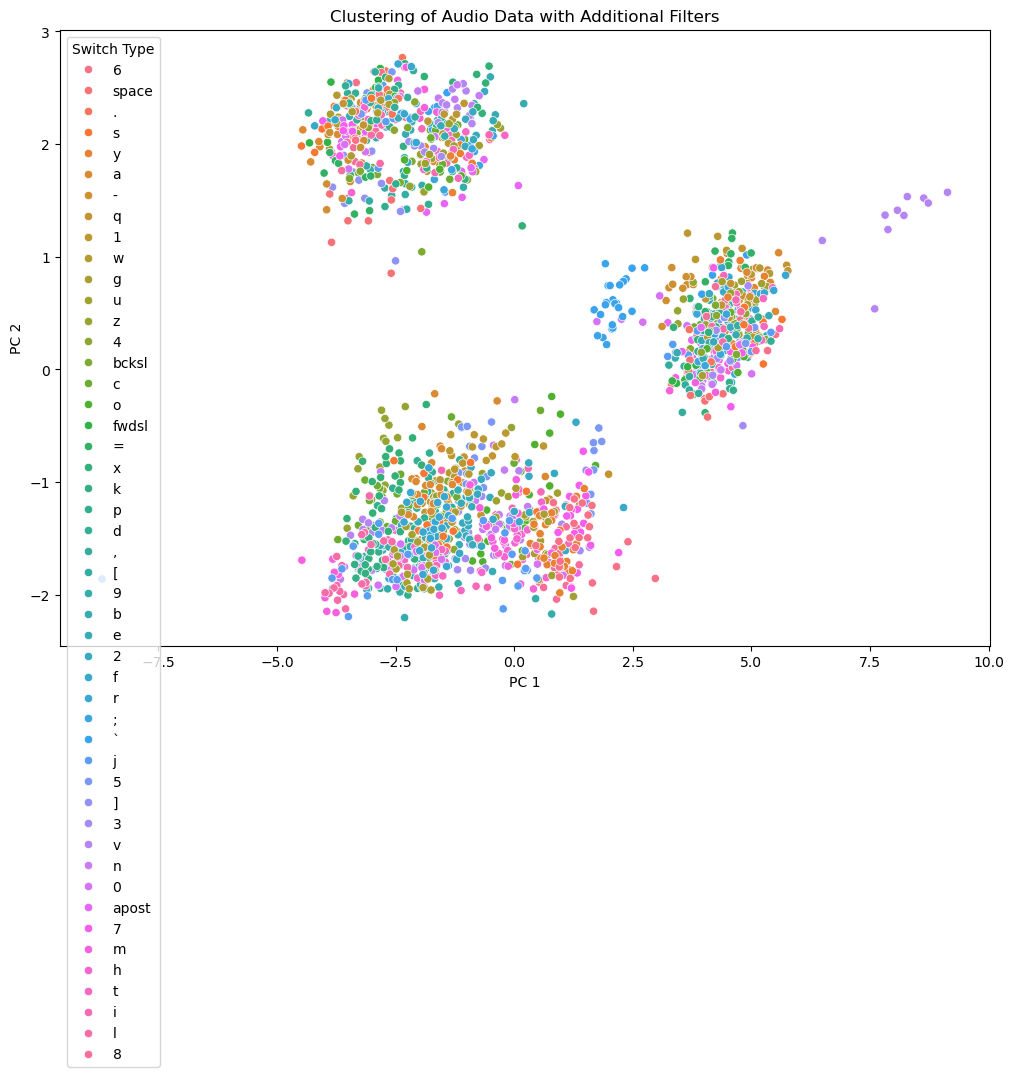

In [51]:
# Filtered Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['key_pressed']) #, style=dataviz_df['keyboard_material'])
plt.title('Clustering of Audio Data with Additional Filters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Switch Type')
plt.show()

**2. Bar Chart for Key Counts**

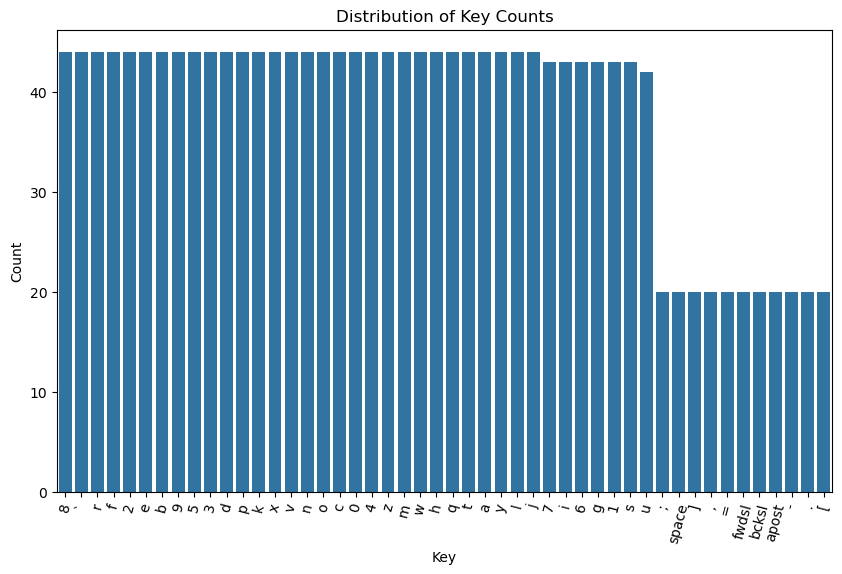

In [56]:
# Count the occurrences of each key
key_counts = dataviz_df['key_pressed'].value_counts()

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=key_counts.index, y=key_counts.values)
plt.title('Distribution of Key Counts')
plt.xlabel('Key')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

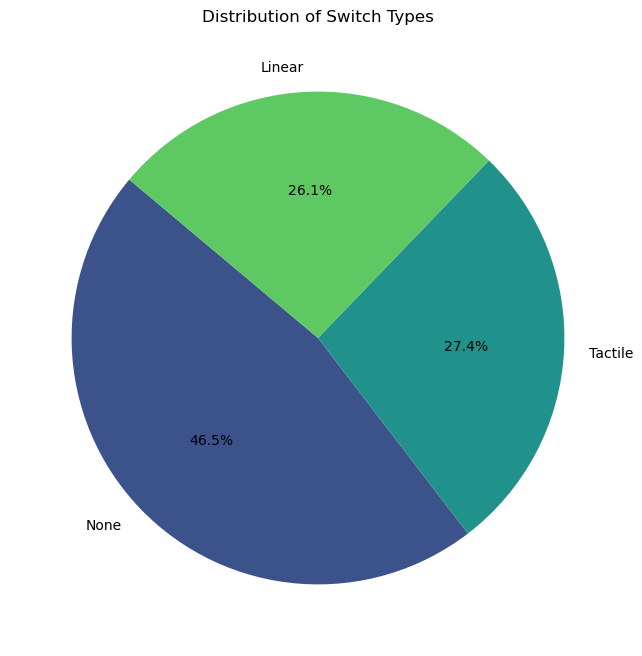

In [57]:
# Pie chart
plt.figure(figsize=(8, 8))
switch_type_counts = dataviz_df['switch_type'].value_counts()
plt.pie(switch_type_counts, labels=switch_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(switch_type_counts)))
plt.title('Distribution of Switch Types')
plt.show()

**4. Average Waveform Visualization**

Step 1: Load and Align Waveforms

You’ll need to align the waveforms for averaging. Here’s a basic approach using peak alignment:


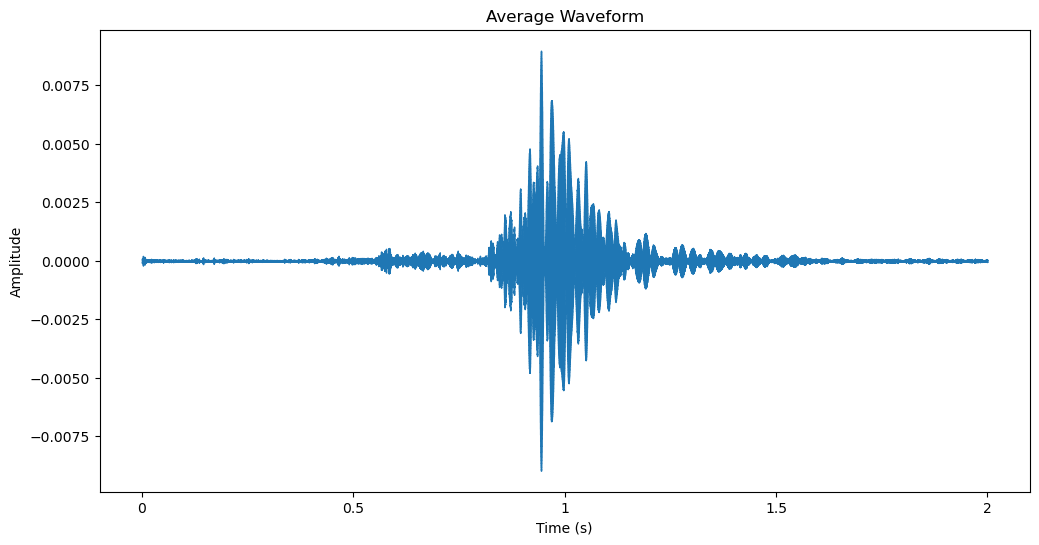

In [66]:
def align_waveforms(waveforms):
    # Align waveforms (basic approach)
    # This assumes that waveforms are already normalized and have the same length
    return np.mean(np.array(waveforms), axis=0)

# Load waveforms and align
waveforms = [librosa.load(f'../preprocessed_data/{file}', sr=None, duration=1.0)[0].tolist() for file in dataviz_df['audio_file'].unique()]
average_waveform = align_waveforms(waveforms)

# Plot average waveform
plt.figure(figsize=(12, 6))
librosa.display.waveshow(average_waveform)
plt.title('Average Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Generate csv for keyboard map

In [ ]:
import pandas as pd
import numpy as np

# Example DataFrame (replace with your actual DataFrame)
# df = pd.read_csv('your_dataframe.csv')

# Function to compute the mean of MFCC features
def compute_mean_mfcc(features_list):
    # Convert list of arrays to a 2D array
    mfcc_array = np.array(features_list)
    # Compute the mean along the first axis
    mean_mfcc = np.mean(mfcc_array, axis=0)
    return mean_mfcc

# Group by 'key_pressed'
grouped_df = df.groupby('key_pressed').agg(
    # Aggregate features by computing the mean MFCC
    average_features=('features', lambda x: compute_mean_mfcc(x)),
    # Count occurrences of each key
    key_count=('key_pressed', 'size')
).reset_index()

# Extract average features
# Assuming the MFCCs have a fixed length, you may want to convert them to a DataFrame
# This will depend on the shape of your MFCC features; here we assume an array length of 13
mfcc_columns = [f'feature_{i+1}' for i in range(len(grouped_df['average_features'][0]))]
average_features_df = pd.DataFrame(grouped_df['average_features'].tolist(), columns=mfcc_columns)

# Concatenate average features with the main DataFrame
final_df = pd.concat([grouped_df[['key_pressed', 'key_count']], average_features_df], axis=1)

# Display the final DataFrame
print(final_df)

# Save the new DataFrame to a CSV if needed
# final_df.to_csv('new_dataframe.csv', index=False)